# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
from fastai.imports import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics, linear_model
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
np.set_printoptions(threshold=50, edgeitems=20)
import seaborn as sns
PATH='Data/'

In [92]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)

In [93]:
df_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [94]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [95]:
df_raw = df_raw.drop(df_raw[(df_raw['GrLivArea']>4000) & (df_raw['SalePrice']<300000)].index)
df_raw['TotalBsmtSF'] = df_raw['TotalBsmtSF'].fillna(0)
df_raw['age'] = df_raw['YrSold'] - df_raw['YearRemodAdd']
df_raw['TotalSF'] = df_raw['TotalBsmtSF'] + df_raw['1stFlrSF'] + df_raw['2ndFlrSF']

In [96]:
cat_vars = ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath',
    'BsmtHalfBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
    'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath',
    'Functional', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC',
    'HouseStyle','KitchenAbvGr', 'KitchenQual', 'LandContour','LandSlope', 'LotConfig', 'LotShape','MSSubClass',
    'MSZoning','MasVnrType','MiscFeature','MoSold','Neighborhood','OverallCond','OverallQual','PavedDrive',
    'PoolQC','RoofMatl','RoofStyle','SaleCondition','SaleType','Street','TotRmsAbvGrd','Utilities', 'YrSold']

contin_vars = ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr','BsmtFinSF1',  'BsmtFinSF2',
   'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage',
   'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF','PoolArea','TotalBsmtSF','TotalSF','WoodDeckSF','YearBuilt',
   'YearRemodAdd','ScreenPorch','age']

In [97]:
for v in cat_vars: df_raw[v] = df_raw[v].astype('category').cat.as_ordered()

In [98]:
train_cats(df_raw)
df, y, nas, mapper = proc_df(df_raw, 'SalePrice', do_scale=True)
df.drop('Id', axis = 1, inplace = True)

In [99]:
test = pd.read_csv(f'{PATH}test.csv', low_memory=False)
test['y'] = 0

In [100]:
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(0)
test['age'] = test['YrSold'] - test['YearRemodAdd']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

In [101]:
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(0)
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(0)
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(0)
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(0)
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(0)
test['GarageCars'] = test['GarageCars'].fillna(0)
test['GarageArea'] = test['GarageArea'].fillna(0)

In [102]:
apply_cats(test, df_raw)

In [103]:
for v in cat_vars: test[v] = test[v].astype('category').cat.as_ordered()

In [104]:
for v in contin_vars:
    df_raw[v] = df_raw[v].astype('float32')
    test[v] = test[v].astype('float32')

In [105]:
df_test, _, _, _ = proc_df(test, 'y', do_scale=True, 
                                  mapper=mapper, na_dict=nas)

In [106]:
n = len(df); n

1456

In [107]:
val_idxs = get_cv_idxs(n, val_pct=.3) ; val_idxs

array([ 497, 1261,  411, 1046, 1033,  613,  218, 1182, 1191,  885, 1099,  607, 1058,  566,  810, 1032,  168,
       1043,  926,   67, ...,  745,   10,  147, 1417,  282,  298, 1205,  291,  678, 1231, 1074, 1232, 1450,
        129,  554,  331,  323, 1286,  724,  538])

In [108]:
valid = df.iloc[val_idxs]
samp_size = len(valid); samp_size

436

In [109]:
valid.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,age,TotalSF,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
497,5,4,-0.457972,-0.134801,2,2,4,4,1,5,...,-0.087809,6,3,9,5,1.695903,0.388739,-0.465160,-0.074329,-0.242712
1264,12,3,-1.702196,-0.648122,2,0,4,4,1,5,...,-0.087809,8,3,1,1,-0.678222,0.251552,-0.465160,-0.074329,-0.242712
411,15,4,1.456217,2.455138,2,0,4,1,1,5,...,-0.087809,1,1,9,5,1.356743,-0.579481,-0.465160,-0.074329,-0.242712
1048,1,4,1.456217,1.146473,2,0,4,4,1,5,...,-0.087809,11,4,9,5,-0.968931,-1.029294,-0.465160,-0.074329,-0.242712
1035,1,4,-0.027280,0.106643,2,0,1,4,1,2,...,-0.087809,1,4,9,5,1.405194,-2.250780,2.149796,-0.074329,-0.242712


## DL

We're ready to put together our models.

We can create a ModelData object directly from out data frame.

In [110]:
md = ColumnarModelData.from_data_frame(PATH, val_idxs, df, y.astype(np.float32), cat_flds=cat_vars, bs=4,
                                       test_df=df_test)

In [111]:
cat_sz = [(c, len(df_raw[c].cat.categories)+1) for c in cat_vars]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [112]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [113]:
max_log_y = np.max(y)
y_range = (0, max_log_y*1.2)

In [139]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.1, 1, [100,50], [0.01,0.01], y_range=y_range)
lr = 1e-3

In [140]:
m.lr_find()

 74%|███████████████████████████████████████████████████▏                 | 189/255 [00:02<00:00, 91.69it/s, loss=9.43]


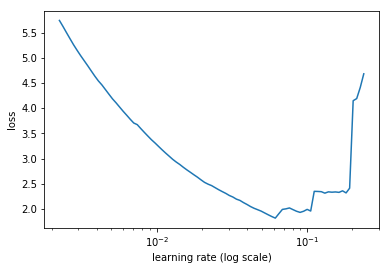

In [141]:
m.sched.plot(100)

### Sample

In [142]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [100,50], [0.001,0.01], y_range=y_range)
lr = 1e-2

In [143]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

In [144]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.135869   0.124023   0.284001  
    1      0.077495   0.075824   0.239167                                                                              
    2      0.057049   0.028941   0.159371                                                                              



[array([0.02894]), 0.15937062505053212]

In [145]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.03278    0.017543   0.126217  
    1      0.027211   0.018665   0.132319                                                                              
    2      0.025297   0.018847   0.130608                                                                              
    3      0.016397   0.016218   0.12239                                                                               
    4      0.017782   0.016908   0.126615                                                                              



[array([0.01691]), 0.12661477031456914]

In [163]:
m.fit(lr, 4, metrics=[exp_rmspe], cycle_len=2)

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.017677   0.02086    0.151212  
    1      0.016205   0.017263   0.128423                                                                              
    2      0.020977   0.021881   0.144117                                                                              
    3      0.021561   0.016649   0.126163                                                                              
    4      0.024589   0.021534   0.142622                                                                              
    5      0.01419    0.017687   0.127874                                                                              
    6      0.025575   0.017177   0.13043                                                                               
    7      0.019216   0.017072   0.129185                                                                           

[array([0.01707]), 0.12918474990950526]

In [122]:
df_id = test['Id']
df_id = pd.DataFrame(df_id, columns = ['Id'])
df_test.drop('Id', axis = 1, inplace = True)

# Predicting the First in the Test Set

In [123]:
test_record = df_test.iloc[0,:] 

cat = test_record[cat_vars].values.astype(np.int64)[None]
contin = test_record.drop(cat_vars).values.astype(np.float32)[None]

#Prediction
model = m.model
model.eval()
prediction = to_np(model(V(cat), V(contin)))
print(f"Sales prediction: {prediction}")

Sales prediction: [[11.69646]]


# Predicting all the values in the test set

In [175]:
pwd

'C:\\Users\\skimel\\fastai\\ames'

In [173]:
results = []
model = m.model
model.eval()
for i, row in df_test.iterrows():
    test_record = row
    cat = test_record[cat_vars].values.astype(np.int64)[None]
    contin = test_record.drop(cat_vars).values.astype(np.float32)[None]
    prediction = np.exp(to_np(model(V(cat), V(contin))))
    results.append(prediction)

In [174]:
flat = [val for sublist in results for val in sublist]

pred = np.array(flat)

pred2 = pd.DataFrame(pred, columns = ['SalePrice'])
final_pred = pd.concat([df_id[['Id']], pred2[['SalePrice']]], axis = 1)
final_pred.to_csv('prednn1.csv', encoding='utf-8', index=False)

### All

In [167]:
val_idxs = get_cv_idxs(n, val_pct=.01)
md = ColumnarModelData.from_data_frame(PATH, val_idxs, df, y.astype(np.float32), cat_flds=cat_vars, bs=4,
                                       test_df=df_test)

In [168]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [100,50], [0.001,0.01], y_range=y_range)
lr = 1e-2

In [169]:
m.fit(lr, 1, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.065128   0.048307   0.233862  



[array([0.04831]), 0.23386234511652598]

In [170]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.036758   0.066529   0.219811  
    1      0.029786   0.017276   0.115107                                                                              
    2      0.023637   0.021014   0.126013                                                                              



[array([0.02101]), 0.12601344633951578]

In [171]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.017611   0.018189   0.125099  
    1      0.014452   0.013137   0.106599                                                                              
    2      0.014047   0.011506   0.106743                                                                              



[array([0.01151]), 0.10674316551700354]

In [172]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.02568    0.036243   0.163537  
    1      0.020451   0.016713   0.131088                                                                              
    2      0.015223   0.021165   0.135525                                                                              
    3      0.016367   0.017416   0.126368                                                                              
    4      0.022826   0.013764   0.106406                                                                              
    5      0.020906   0.012999   0.11059                                                                               
    6      0.01457    0.022294   0.135871                                                                              
    7      0.014803   0.018063   0.128284                                                                           

[array([0.01806]), 0.12828417548483087]

## RF

In [101]:
from sklearn.ensemble import RandomForestRegressor

In [102]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [103]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [104]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.98086411192483902,
 0.92614447508562714,
 0.9193358549649463,
 0.11557443993375387)